In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
https://github.com/mggg/Alaska/blob/master/FKT.py

Created on Wed May 15 11:54:57 2019
@author: daryl
#######################################################################
# BASED On An Original Sage Version by:
# AUTHOR: Dr. Christian Schridde
# E-MAIL: christianschridde [at] googlemail [dot] com
#
# DESCRIPTION: Implementation of the FKT-algorithm
#
# INPUT:  Adjacency matrix A of a undirected loop-free planar graph G
# OUTPUT: The number of perfect matchings of G
########################################################################
"""

import networkx as nx #Requires at least netwrokx 2.3+
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import time

#Helper Functions
def doNothing():
    return 0;

def find_faces(embd):
    

    #Returns a list of faces of the planar embedding by 
    #the edges that bound the face
    ed_list = list(embd.edges())
    faces=[]
    
    for ed in embd.edges():
        if ed in ed_list:
            faces.append(embd.traverse_face(ed[0],ed[1]))
            
            for i in range(len(faces[-1])):
                ed_list.remove((faces[-1][i],faces[-1][(i+1)%len(faces[-1])]))
                
    face_edges=[]
    for face in faces:
        face_edges.append([])
        for i in range(len(face)):
            face_edges[-1].append((face[i],face[(i+1)%len(face)]))
            
                
    return face_edges


def toSkewSymmetricMatrix(A):
    #Skew--symmetrize a matrix
     
    A[(A==1).T] = -1

    return A

def numberOfClockwiseEdges(face, edgesT1):

    #Iterate over edges of a face to determine
    #the number of positive orientations

    clockwise = 0
    for edge in face:
        try:
            edgesT1.index(edge)
        except ValueError:
            doNothing()
        else:
            clockwise += 1
    return clockwise


def isClockwise(e,face):
    #Checks orientation of an edge on a face
    try:
        face.index(e);
    except ValueError:
        return False
    else:
        return True

#Main Function
def FKT(A):
    n = len(A)
    B_graph = A[:]

    G = nx.Graph(A)

    tf, embd = nx.check_planarity(G)
    
    if embd is None:
        return 0

    faces = find_faces(embd)

    T1 = nx.minimum_spanning_tree(G)
    T1 = nx.Graph(T1)

    mask = np.random.randint(2, size=(n, n))
    mask = ((mask + mask.T) == 1)

    B_digraph = A * mask

    G = nx.DiGraph(B_digraph)

    edgesT1 = T1.edges();
    adj_T1 = (nx.adjacency_matrix(T1)).todense();

    for edge in edgesT1:
        if (B_digraph[edge[0], edge[1]] == 0):
            adj_T1[edge[0], edge[1]] = 0
        else:
            adj_T1[edge[1], edge[0]] = 0

    T1 = nx.DiGraph(adj_T1)
    edgesT1 = list(T1.edges())
    if embd is not None:
        faces.sort(key=len)
        faces.reverse()
        faces.pop(0)
        
    if embd is not None:
        while (len(faces) > 0):
            index = -1;
            for face in faces:
                countMissingEdges = 0;
                missingEdge = 0;
                index += 1;
                for edge in face:
                    try:
                        idx1 = edgesT1.index(edge);
                    except ValueError:
                        try:
                            idx2 = edgesT1.index((edge[1], edge[0]));
                        except ValueError:
                            countMissingEdges += 1;
                            missingEdge = edge;
                        else:
                            doNothing();
                    else:
                        doNothing();

                if (countMissingEdges == 1):
                # in this face, only one edge is missing.
                # Place the missing edge such that the total number
                # of clockwise edges of this face is odd
                # add this edge to the spanning tree
                    if ((numberOfClockwiseEdges(face, edgesT1)) % 2 == 1):
                    # insert counterclockwise in adj_T1;
                        if (isClockwise(missingEdge, face) == False):
                            adj_T1[missingEdge[0], missingEdge[1]] = 1;
                        else:
                            adj_T1[missingEdge[1], missingEdge[0]] = 1;
                    else:
                    # insert clockwise in adj_T1
                        if (isClockwise(missingEdge, face) == True):
                            adj_T1[missingEdge[0], missingEdge[1]] = 1;
                        else:
                            adj_T1[missingEdge[1], missingEdge[0]] = 1;

                # rebuild the graph
                    T1 = nx.DiGraph(adj_T1);
                    edgesT1 = list(T1.edges());

                # remove the face that was found
                    faceFound = faces.pop(index);
                    break;
        try: 
            return math.sqrt(np.linalg.det(toSkewSymmetricMatrix(adj_T1)));
        except ValueError: 
            pass    
    

In [7]:
G = nx.grid_graph([10,10], periodic=False)

In [8]:
w_edges = []
from tqdm.notebook import tqdm

matching = []
while len(G.edges)>0:
    w_edges = []
    for e in tqdm(G.edges):

        G_e = G.copy()
        G_e.remove_node(e[0])
        G_e.remove_node(e[1])
        count = []
        for G_ee in [G_e.subgraph(c) for c in nx.connected_components(G_e)]:
            A = nx.adj_matrix(G_ee).todense()
            try:
                fkt_val = FKT(A)
            except IndexError:
                fkt_val = 0
            count.append(fkt_val)
        if len(count)>0:
            if min(count) == 0:
                w_edges.append(0)
            else:
                w_edges.append(min(count))
        
    if len(w_edges) == 0:
        break
    e_to_matching = random.choices(list(G.edges), weights=w_edges)[0]
    matching.append(e_to_matching)
    G.remove_node(e_to_matching[0])
    G.remove_node(e_to_matching[1])

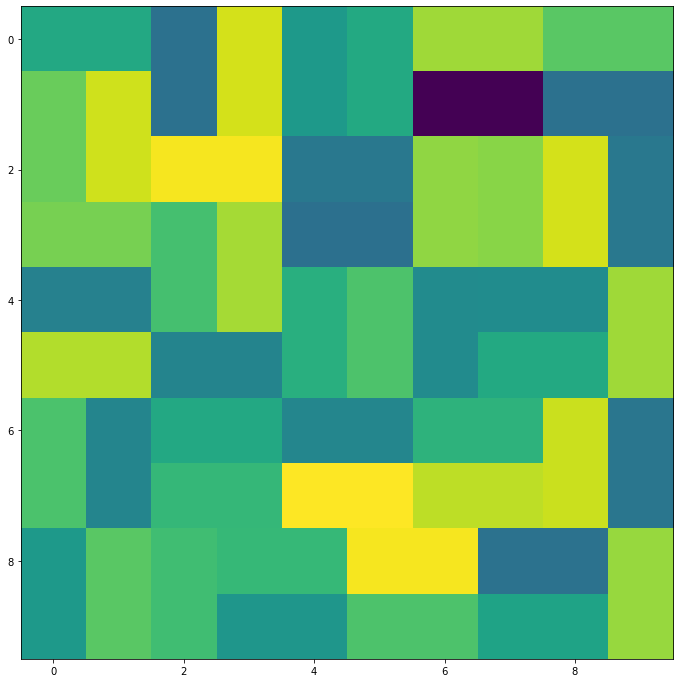

In [9]:
tiling = np.zeros((10,10))
for i in range(len(matching)):
    u, v = matching[i]
    value = np.random.uniform(0,1)+0.5
    tiling[u[0], u[1]] = value
    tiling[v[0], v[1]] = value
plt.figure(figsize = (12,12))
plt.imshow(tiling)